In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
pi = np.pi
np.set_printoptions(precision=3)

def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 5 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw
    
    
def computeGreenNormal2D( x, y, xj, yj , normalx, normaly ):
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2 
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn

def computeSolidAngle( xp, yp, xh1, yh1, xh2, yh2 ):
    vector1 = np.array( [ xh1-xp, yh1-yp ])
    vector2 = np.array( [ xh2-xp, yh2-yp ])
    vnorm1 = np.linalg.norm( vector1 )
    vnorm2 = np.linalg.norm( vector2 )
    solidAngle = np.arccos( np.dot( vector1, vector2 ) / vnorm1 / vnorm2 )
#     if np.isnan( solidAngle ):
#         solidAngle = pi / 16
    return solidAngle/2/pi


def assembleMatrixSystem( X, Y, N, U0, AOA ):
    ## check if the geometry has sharp trailing edge
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createPeriodicSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## correct normal direction
    nx = binormal * nx
    ny = binormal * ny
    
    ## generate system of equations
    A = np.identity( N + 1 )
    b = np.zeros( N + 1 )
    dt = 1/ N

    tol = 1e-12
    for i in range( N ):
        b[i] = U0 * ( x[i] * np.cos( AOA * pi / 180 ) +  y[i] * np.sin( AOA * pi / 180 ) )
        for j in range( N ):
            ## using trapezoidal rule
            
            gij1 = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j] ) * ds_dt[j] * dt / 2
            gij2 = computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1] ) * ds_dt[j+1] * dt / 2
            cond1 = np.abs( gij1 ) > tol and i != j
            cond2 = np.abs( gij2 ) > tol and i != j+1 or ( i != 0 and j == N)
            if cond1 == True or cond2 == True:
                gij1 = computeSolidAngle( x[i], y[i], x[j], y[j], x[j+1], y[j+1] )/2
                gij2 = gij1
                if np.isnan(gij1) == True:
                    gij1 = .25/N
                    gij2 = .25/N

            # first part
            if (i != j):
                A[i, i] = A[i, i] - gij1
                A[i, j] = A[i, j] + gij1
            
            # second part
            if (i != j+1) and not( i ==0 and j+1 == N ): ## if i == j+1, coefficient is not affected 
                A[i, i] = A[i, i] - gij2
                A[i, j+1] = A[i, j+1] + gij2
    
    ## apply periodic boundary conditions for last term
    A[N, 0] = 1
    A[N, -1] = -1
        
    return x, y, theta, A, b, ds_dt


        



    



/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


[[ 8.108e-01  4.249e-03  5.428e-03 ...  5.428e-03  1.415e-01  0.000e+00]
 [ 4.883e-04  5.140e-01  1.119e-03 ...  1.080e-01  2.082e-01  1.123e-01]
 [ 3.721e-03  4.209e-03  5.015e-01 ...  1.841e-01  1.160e-01  2.009e-02]
 ...
 [ 2.009e-02  1.160e-01  1.841e-01 ...  5.015e-01  4.209e-03  3.721e-03]
 [ 1.123e-01  2.082e-01  1.080e-01 ...  1.119e-03  5.140e-01  4.883e-04]
 [ 1.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00 -1.000e+00]]
The norm of the error is  0.006927296624608865


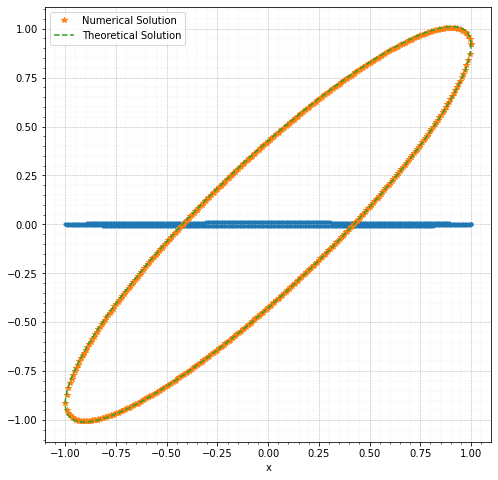

In [2]:
N = 512
U0 = 1 
thic = .01
AOA = 25
## create geometry
t = np.linspace( 0, 1, 512*2 )
dt = t[1] - t[0] 

a = 1
b = thic
c = (a**2-b**2)**.5

X = .5*(a+b) * np.cos( 2 * pi * t )
Y = .5*(a+b) * np.sin( 2 * pi * t )

Z = X + 1j * Y ## circular
z = Z + c**2/(4*Z) ## elliptical
X = np.real(z)
Y = np.imag(z)

## create system of equations
x, y, theta, A, b, ds_dt = assembleMatrixSystem( X, Y, N, U0, AOA )


## solve system of equations
phi = np.linalg.solve( A, b )
print( A )


## theoretical solution
t = np.linspace( 0, 1, N+1 )

a = 1
b = thic
c = (a**2-b**2)**.5

X = .5*(a+b) * np.cos( 2 * pi * t )
Y = .5*(a+b) * np.sin( 2 * pi * t )

Z = X + 1j * Y ## circular
z = Z + c**2/(4*Z) ## elliptical
X = np.real(z)
Y = np.imag(z)

## theoretical solution
eta = np.arctan2(np.imag(Z), np.real(Z))
w = (a+b)*U0*np.cos(eta - AOA*pi/180)

## plot solution
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel('x')
ax.plot( np.concatenate( (x,[x[0]]) ), np.concatenate( (y,[y[0]]) ), '.' )

ax.plot( x, phi, '*',label="Numerical Solution" )
ax.plot( np.real(z), np.real(w), '--', label="Theoretical Solution" )

print( "The norm of the error is ", np.linalg.norm( phi-np.real(w))/N )

# ## compute pressure coefficient
# dphi_ds = np.diff( phi ) / np.diff( np.linspace(0, 1, N + 1)) / ds_dt[1:]
# cp = 1 - (dphi_ds/U0)**2
# ax.plot( (x[:-1]), cp, '.', label="Pressure Coefficient" ) 
ax.legend()



